**用于估计幅度调制噪声包络的 DEMON 谱的 Python 实现。提供两个版本：平方律 DEMON 与希尔伯特变换 DEMON。根据具体应用场景，任一算法都可能更合适。两者都期望输入原始数据的数组以及滤波参数，并返回一个包含对输入数据包络估计值的输出数组。**


In [62]:
from scipy.signal import butter, iirfilter, decimate, hilbert, sosfiltfilt, resample_poly
from numpy import square, sqrt, mean, abs as np_abs
from math import floor
from typing import Tuple, Optional
import numpy as np
from scipy.fft import fft, fftfreq
import librosa, librosa.display
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [63]:
def butter_bandpass(low, high, sample_rate, order):
    """
    生成巴特沃斯带通滤波器系数
    
    :param low: 低频截止频率 (Hz)
    :param high: 高频截止频率 (Hz)
    :param sample_rate: 采样频率 (Hz)
    :param order: 滤波器阶数
    :return: 滤波器系数 (b, a)
    """

    sos = iirfilter(order, [low/(sample_rate*0.5), high/(sample_rate*0.5)], btype='band', ftype='butter', output='sos')
    
    return sos

In [64]:
def process_envelope(x_env, cutoff, sample_rate, env_sr, hp_hz, order):
    """
    处理包络的通用步骤：抽取、平方根和去均值
    
    :param x: 输入信号
    :param cutoff: 截止频率 (Hz)
    :param sample_rate: 原始采样频率 (Hz)
    :return: 处理后的包络信号
    """
    x_ds = resample_poly(x_env, env_sr, sample_rate)
    f_lo = max(1e-3, hp_hz)
    f_hi = min(cutoff, env_sr*0.49)
    sos_bp = iirfilter(order, [f_lo/(env_sr*0.5), f_hi/(env_sr*0.5)], btype='band', ftype='butter', output='sos')
    env = sosfiltfilt(sos_bp, x_ds)
    decimation_rate = sample_rate / env_sr

    return env, decimation_rate

In [65]:
def square_law(x, cutoff, high, low, sample_rate, env_sr, hp_hz, order):
    """
    平方律DEMON算法：用于估计调幅噪声的包络
    
    算法步骤：带通滤波 -> 信号平方 -> 抽取 -> 平方根 -> 去均值
    
    :param x: 输入信号数组
    :param cutoff: 包络提取的截止频率 (Hz)
    :param high: 带通滤波器高频截止 (Hz)
    :param low: 带通滤波器低频截止 (Hz)
    :param sample_rate: 采样频率 (Hz)
    :return: 估计的包络信号
    :raises ValueError: 当带宽超过通带中心频率时触发
    """
    sos_c = butter_bandpass(low, high, sample_rate, order)
    x_filtered = sosfiltfilt(sos_c, x)
    x_env = np.square(x_filtered)  
    envelope, decimation_rate = process_envelope(x_env, cutoff, sample_rate, env_sr, hp_hz, order)
    
    return envelope, x_filtered, decimation_rate

In [66]:
def hilbert_detector(x, cutoff, high, low, sample_rate, env_sr, hp_hz, order):
    """
    希尔伯特变换DEMON算法：用于估计调幅噪声的包络
    
    算法步骤：带通滤波 -> 希尔伯特变换 -> 取绝对值 -> 抽取 -> 平方根 -> 去均值
    
    :param x: 输入信号数组
    :param cutoff: 包络提取的截止频率 (Hz)
    :param high: 带通滤波器高频截止 (Hz)
    :param low: 带通滤波器低频截止 (Hz)
    :param sample_rate: 采样频率 (Hz)
    :return: 估计的包络信号
    """
    sos_c = butter_bandpass(low, high, sample_rate, order)
    x_filtered = sosfiltfilt(sos_c, x)
    x_env = np_abs(hilbert(x_filtered)) 
    envelope, decimation_rate = process_envelope(x_env, cutoff, sample_rate, env_sr, hp_hz, order)

    return envelope, x_filtered, decimation_rate

In [67]:
def visualize_demon(x, sample_rate, low, high, cutoff, env_sr, hp_hz, order, title):
    """Visualize DEMON algorithm processing results"""
    signal_duration = len(x) / sample_rate

    t_original = np.linspace(0, signal_duration, len(x))
    
    square_envelope, square_filtered, square_decim_rate = square_law(
        x, cutoff, high, low, sample_rate, env_sr, hp_hz, order)
    
    hilbert_envelope, hilbert_filtered, hilbert_decim_rate = hilbert_detector(
        x, cutoff, high, low, sample_rate, env_sr, hp_hz, order)
    
    # 计算包络时间轴
    square_duration = len(square_envelope) / (sample_rate / square_decim_rate)
    t_square_env = np.linspace(0, square_duration, len(square_envelope))
    
    hilbert_duration = len(hilbert_envelope) / (sample_rate / hilbert_decim_rate)
    t_hilbert_env = np.linspace(0, hilbert_duration, len(hilbert_envelope))
    
    # 创建图形
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle(title, fontsize=16, y=0.98)
    gs = gridspec.GridSpec(4, 2, figure=fig, hspace=0.3, wspace=0.2)
    
    # 1. 原始信号
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(t_original, x)
    ax1.set_title('Original Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. 平方律滤波信号
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(t_original, square_filtered)
    ax2.set_title('Square-law Filtered Signal')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Amplitude')
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # 3. 希尔伯特滤波信号
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(t_original, hilbert_filtered)
    ax3.set_title('Hilbert Filtered Signal')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Amplitude')
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # 4. 平方律包络
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.plot(t_square_env, square_envelope)
    ax4.set_title('Square-law Envelope (AC-coupled for DEMON)')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Amplitude')
    ax4.grid(True, linestyle='--', alpha=0.7)
    
    # 5. 希尔伯特包络
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(t_hilbert_env, hilbert_envelope)
    ax5.set_title('Hilbert envelope (AC-coupled for DEMON)')
    ax5.set_xlabel('Time (s)')
    ax5.set_ylabel('Amplitude')
    ax5.grid(True, linestyle='--', alpha=0.7)
    
    # 6. 包络对比
    ax6 = fig.add_subplot(gs[3, :])
    min_len = min(len(square_envelope), len(hilbert_envelope))
    t_compare = np.linspace(0, min(square_duration, hilbert_duration), min_len)
    ax6.plot(t_compare, square_envelope[:min_len], label='Square-law', 
             linestyle='-', linewidth=2, alpha=0.7)
    ax6.plot(t_compare, hilbert_envelope[:min_len], label='Hilbert', 
             linestyle='--', linewidth=2, alpha=0.7)
    ax6.set_title('Envelope Comparison')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Amplitude')
    ax6.legend(loc='upper right')
    ax6.grid(True, linestyle='--', alpha=0.7)
    
    # 参数文本框
    param_text = (f'Parameters:\n'
                 f'Sampling Rate: {sample_rate} Hz\n'
                 f'Bandpass: {low}-{high} Hz\n'
                 f'Envelope Cutoff: {cutoff} Hz\n'
                 f'Filter Order: {order}')
    plt.figtext(0.02, 0.01, param_text, fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.9, pad=5))
    
    plt.subplots_adjust(top=0.94, bottom=0.08)
    plt.show()

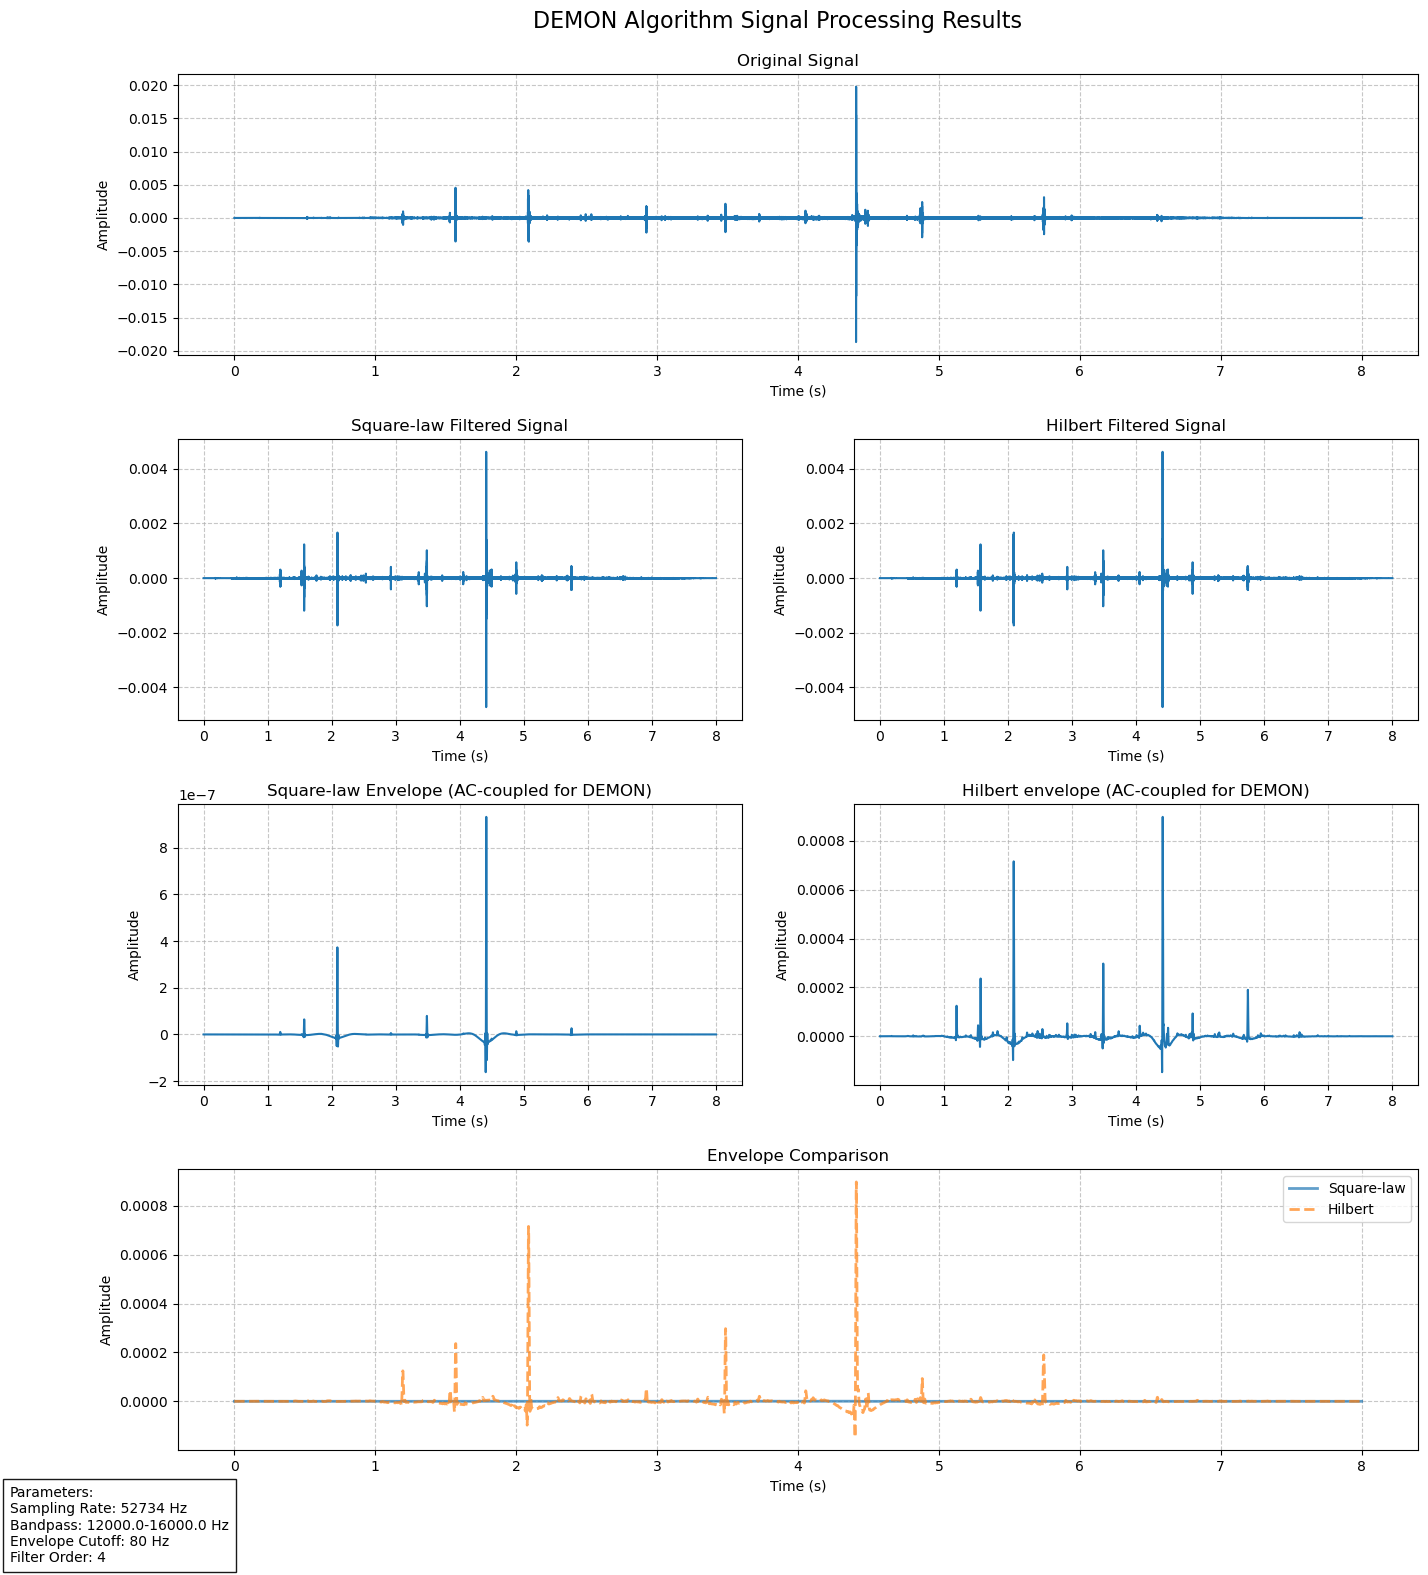

In [68]:
audio_file = r"E:\数据集\ShipEar\data_preprocessing\7_Frame_Windows_8s_50%\6__10_07_13_marDeCangas_Entra_1.wav"

waveform, sample_rate = librosa.load(audio_file, sr=None)

visualize_demon(waveform, sample_rate, low=12000.0, high=16000.0, cutoff=80, env_sr=2000, hp_hz=2.5, order=4, title="DEMON Algorithm Signal Processing Results")